In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as LA
from scipy.signal import lsim, butter, lfilter
from scipy.integrate import solve_ivp
import cvxpy as cp
import opentorsion as ot

In [5]:
def propulsion_system():
    '''
    Parameters from: https://journals.sagepub.com/doi/full/10.1177/14759217211004232
    '''
    J1 = 1.347e4 # propeller
    J3 = 5.590e2
    J5 = 5.120e2
    J7 = 4.870e2
    J9 = 1.410e2
    J11 = 1.740e2
    J13 = 4.415e3 # motor
    
    k2 = 5.88e7
    k4 = 5.95e7
    k6 = 1.12e8
    k8 = 6.93e8
    k10 = 5.09e8
    k12 = 1.43e8
    damping = 180 # damping in steel_shafts
    propeller_damping = 0*120e3
    
    shafts, disks = [], []
    disks.append(ot.Disk(0, I=J1, c=propeller_damping))
    shafts.append(ot.Shaft(0, 1, None, None, k=k2, I=0, c=damping))
    disks.append(ot.Disk(1, I=J3))
    shafts.append(ot.Shaft(1, 2, None, None, k=k4, I=0, c=damping))
    disks.append(ot.Disk(2, I=J5))
    shafts.append(ot.Shaft(2, 3, None, None, k=k6, I=0, c=damping))
    disks.append(ot.Disk(3, I=J7))
    shafts.append(ot.Shaft(3, 4, None, None, k=k8, I=0, c=damping))
    disks.append(ot.Disk(4, I=J9))
    shafts.append(ot.Shaft(4, 5, None, None, k=k10, I=0, c=damping))
    disks.append(ot.Disk(5, I=J11))
    shafts.append(ot.Shaft(5, 6, None, None, k=k12, I=0, c=damping))
    disks.append(ot.Disk(6, I=J13))
    
    assembly = ot.Assembly(shafts, disk_elements=disks)
    _, f, _ = assembly.modal_analysis()
    print("Eigenfrequencies: ", f.round(2))

    return assembly

In [6]:
def newmark_H1(M, C, K, gamma_par, beta_par):
    """
    Matrix used in creation of Newmark-beta state matrix.
    
    Parameters:
    M : numpy.ndarray
        Mass matrix
    C : numpy.ndarray
        Damping matrix
    K : numpy.ndarray
        Stiffness matrix
    gamma_par : float
        Parameter of the Newmark-beta method
    beta_par : float
        Parameter of the Newmark-beta method

    Returns:
    lambda function
        The H1 matrix as a lambda function, input is the timestep dt
    """
    
    return lambda dt : np.vstack([np.hstack([M + gamma_par*dt*C, gamma_par*dt*K]), np.hstack([beta_par*dt**2*C, M + beta_par*dt**2*K])])

In [7]:
def newmark_H0(M, C, K, gamma_par, beta_par):
    """
    Matrix used in creation of Newmark-beta state matrix.
    
    Parameters:
    M : numpy.ndarray
        Mass matrix
    C : numpy.ndarray
        Damping matrix
    K : numpy.ndarray
        Stiffness matrix
    gamma_par : float
        Parameter of the Newmark-beta method
    beta_par : float
        Parameter of the Newmark-beta method

    Returns:
    lambda function
        The H0 matrix as a lambda function, input is the timestep dt
    """
    
    return lambda dt : np.vstack([np.hstack([M - (1-gamma_par)*dt*C, -(1-gamma_par)*dt*K]), np.hstack([-(0.5-beta_par)*dt**2*C, M - (0.5-beta_par)*dt**2*K])])

In [10]:
assembly = propulsion_system()
M, C, K = assembly.M(), assembly.C(), assembly.K()  # Mass, damping and stiffness matrices
ndof = assembly.dofs
gamma_parameter = 0.5
beta_parameter = 0.25

Eigenfrequencies:  [  0.     0.    11.41  11.41  48.93  48.93  78.82  78.82 115.27 115.27
 268.61 268.61 522.81 522.81]


In [67]:
time = np.arange(0, 10.0001, 0.0001)
step_size = np.mean(np.diff(time))

H1 = newmark_H1(M, C, K, gamma_parameter, beta_parameter)
H0 = newmark_H0(M, C, K, gamma_parameter, beta_parameter)

state_vector = np.zeros((2*ndof, 1))
states = np.copy(state_vector)

u = np.zeros(2*ndof)
u[0] += 10000/M[0,0]

def state_derivative(t, x):
    A = LA.inv(H1(step_size)) @ H0(step_size)
    
    return A @ x + u

sol = solve_ivp(state_derivative, (time[0], time[-1]), np.zeros(2*ndof), t_eval=time)
print(sol.y.shape)

(14, 100001)


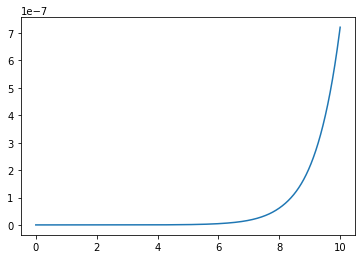

In [69]:
#torque_meas = 6.93e8*(sol.y[7+4,:]-sol.y[7+3,:])
plt.plot(time, sol.y[9,:])
#plt.plot(time, torque_meas)
plt.show()

In [ ]:
# add gaussian white noise to the measurement (measurement and process noise)
r = np.random.multivariate_normal(np.zeros(R_.shape[0]), R_, tout.shape[0])